In [633]:
#%pip install --ignore-installed --upgrade tensorflow 
#%pip install opencv-python
#%pip install --upgrade albumentations --user
#%pip install pandas
#%pip install numpy
#%pip install matplotlib


In [634]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
import albumentations as A # used for image augmentation
from PIL import Image #used for importing images
import re
import os,glob
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard




In [635]:
data = pd.read_csv('./Genshin_Dataset.csv')
data.head(24)


,Name,Model,Region,Vision,Weapon,Revenue,Year Released
0,Albedo,https://i.postimg.cc/vHqgw9cj/unnamed.jpg,Mondstadt,Geo,Sword,"$11,816,107",2021
1,Ayaka,https://i.postimg.cc/mZP9x58Q/ayaka.jpg,Inazuma,Cryo,Sword,"$16,451,006",2021
2,Ayato,https://i.postimg.cc/3JpDNDMN/ayato.jpg,Inazuma,Hydro,Sword,"$14,481,796",2022
3,Childe (Tartaglia),https://i.postimg.cc/RZBJHV9R/childe.jpg,Liyue,Hydro,Bow,"$13,443,619",2020
4,Cyno,https://i.postimg.cc/bNHN40cx/cyno.jpg,Sumeru,Electro,Polearm,"$13,797,833",2022
5,Eula,https://i.postimg.cc/NMHQDmkr/eula.jpg,Mondstadt,Cryo,Claymore,"$12,619,390",2021
6,Ganyu,https://i.postimg.cc/wM5g8zPq/ganyu.jpg,Liyue,Cryo,Bow,"$15,669,918",2021
7,Hu Tao,https://i.postimg.cc/6pW5K7tD/HuTao.jpg,Liyue,Pyro,Polearm,"$12,481,634",2021
8,Itto,https://i.postimg.cc/NGRgr803/Itto.jpg,Inazuma,Geo,Claymore,"$13,404,072",2022
9,Kazuha,https://i.postimg.cc/NFvBzFdC/kazuha.jpg,Inazuma,Anemo,Sword,"$9,807,112",2021


In [636]:
# given the filepath to the image, we can visualize the image
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

In [637]:
# transformations using albumentations library
vertical_transform = A.Compose([A.VerticalFlip(p=1)])
horizontal_transform = A.Compose([A.HorizontalFlip(p=1)])


In [638]:
revenues = data['Revenue']
revenues = revenues.map(lambda x: int(re.sub(",", "", x[1:]))) # removes $ and commas from the revenue
data['Revenue (as int)'] = revenues

In [639]:
print("Minimum revenue a character made: ", min(data['Revenue (as int)']))
print("Maximum revenue a character made: ", max(data['Revenue (as int)']))
# using the min max revenue a character made, we divided the data into 2 classifications 
# each classification represents below $15M (0) and above $15M (1)
for row, col in data.iterrows():
    if col['Revenue (as int)'] <= 15000000:
        data.at[row, 'Revenue Classifier'] = 0
    else:
        data.at[row, 'Revenue Classifier'] = 1

data.head()

Minimum revenue a character made:  6825814
Maximum revenue a character made:  33020905


,Name,Model,Region,Vision,Weapon,Revenue,Year Released,Revenue (as int),Revenue Classifier
0,Albedo,https://i.postimg.cc/vHqgw9cj/unnamed.jpg,Mondstadt,Geo,Sword,"$11,816,107",2021,11816107,0.0
1,Ayaka,https://i.postimg.cc/mZP9x58Q/ayaka.jpg,Inazuma,Cryo,Sword,"$16,451,006",2021,16451006,1.0
2,Ayato,https://i.postimg.cc/3JpDNDMN/ayato.jpg,Inazuma,Hydro,Sword,"$14,481,796",2022,14481796,0.0
3,Childe (Tartaglia),https://i.postimg.cc/RZBJHV9R/childe.jpg,Liyue,Hydro,Bow,"$13,443,619",2020,13443619,0.0
4,Cyno,https://i.postimg.cc/bNHN40cx/cyno.jpg,Sumeru,Electro,Polearm,"$13,797,833",2022,13797833,0.0


In [640]:
images_arr = [] # array of images
revenue_arr = [] # array of revenues for each character
counter = 0

# iterates over the character images in the folder 
# returns a tuple where the 3rd element is a list of the character names
for e_image in os.walk('./Genshin Characters/'):

    # iterates over the list of the character names
    for img_name in e_image[2]:
        file_path = './Genshin Characters/{}'.format(img_name)
        image = cv2.imread(file_path, cv2.COLOR_BGR2RGB) # converts the image to color
        image = cv2.resize(image, (200, 200)) # resizing images to same size
        
        # the following code changes pixels to numeric data
        image = np.array(image)
        image = image.astype('float32')
        image /= 255
        
        # transform function takes in the image as the parameter
        # the output is a dictionary with 'image' as the key and the transformed image as the value
        # so, we extract the value by giving it the key
        vertical_image = vertical_transform(image=image)['image'] 
        horizontal_image = horizontal_transform(image=image)['image']
       
        images_arr.append(image)
        images_arr.append(vertical_image)
        images_arr.append(horizontal_image)
        
        revenue_arr.append(data['Revenue Classifier'][counter])
        revenue_arr.append(data['Revenue Classifier'][counter])
        revenue_arr.append(data['Revenue Classifier'][counter])
        counter += 1

        
    



In [642]:
print(len(revenue_arr))
print(len(images_arr))

72
72


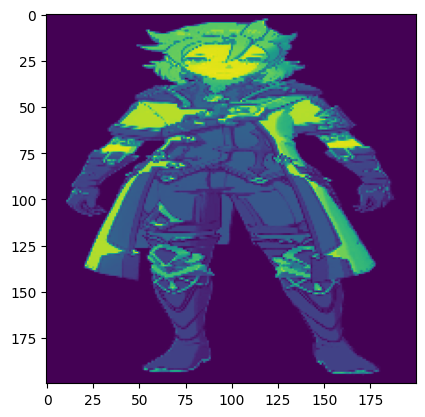

In [643]:
images_arr = np.array(images_arr).astype(np.float32)
images_arr = images_arr.reshape(72, 200*200, 3)
images_arr = images_arr[:, :, 1] # only green spectrum
plt.imshow(images_arr[0].reshape(200,200))

In [644]:
revenue_arr = list(map(lambda x: x.astype(np.int32), revenue_arr))

In [645]:
img_train, img_test, rev_train, rev_test = train_test_split(images_arr, revenue_arr, test_size=0.2, shuffle = True, random_state = 20)

In [646]:
img_train.shape


(57, 40000)

In [647]:
n_classes = 2
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dense(n_classes))
model.add(tf.keras.layers.Softmax()) # softmax takes some input _> some probabiltiy distribution
# you cna use cross entropy as your loss
# your final layer a single output neuron -> that holds what ever the regression prediction is
# for classification your final layer is n_classes of neurons -> where accuracy is argmax(final_layer) is the class


In [648]:
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [649]:
print(len(rev_train))
print(len(img_train))

57
57


In [658]:
model.fit(img_train, np.array(rev_train), epochs=15, validation_data = (img_test, np.array(rev_test)))

Epoch 1/15
2/2 [==============================] - 0s 159ms/step - loss: 0.7088 - accuracy: 0.5789 - val_loss: 0.6955 - val_accuracy: 0.6667
Epoch 2/15
2/2 [==============================] - 0s 84ms/step - loss: 0.7094 - accuracy: 0.4386 - val_loss: 0.6954 - val_accuracy: 0.6000
Epoch 3/15
2/2 [==============================] - 0s 80ms/step - loss: 0.7002 - accuracy: 0.5263 - val_loss: 0.6989 - val_accuracy: 0.2000
Epoch 4/15
2/2 [==============================] - 0s 81ms/step - loss: 0.6989 - accuracy: 0.4035 - val_loss: 0.7094 - val_accuracy: 0.8667
Epoch 5/15
2/2 [==============================] - 0s 78ms/step - loss: 0.7068 - accuracy: 0.4561 - val_loss: 0.6965 - val_accuracy: 0.6667
Epoch 6/15
2/2 [==============================] - 0s 81ms/step - loss: 0.6979 - accuracy: 0.5263 - val_loss: 0.7010 - val_accuracy: 0.2000
Epoch 7/15
2/2 [==============================] - 0s 76ms/step - loss: 0.6994 - accuracy: 0.6316 - val_loss: 0.6990 - val_accuracy: 0.6667
Epoch 8/15
2/2 [==========

In [651]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_93 (Dense)            (None, 128)               5120128   
                                                                 
 re_lu_62 (ReLU)             (None, 128)               0         
                                                                 
 dense_94 (Dense)            (None, 128)               16512     
                                                                 
 re_lu_63 (ReLU)             (None, 128)               0         
                                                                 
 dense_95 (Dense)            (None, 2)                 258       
                                                                 
 softmax_31 (Softmax)        (None, 2)                 0         
                                                                 
Total params: 5,136,898
Trainable params: 5,136,898
N